In [1]:
import pandas as pd
import numpy as np
import h5py
import os
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import nn, optim
from collections import OrderedDict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
ancho = 160
alto = 129
canales = 3
pixeles = ancho*alto*canales
cantidadClases = 5
clases = ['Banano', 'Granada', 'Kiwi', 'Mango', 'Pitaya']
batchSize = 128

In [3]:
def view_classify(img, ps):
  ps = ps.data.numpy().squeeze()
  fig, (ax1, ax2) = plt.subplots(figsize=(16,13), ncols=2)
  ax1.imshow(img.numpy().transpose((1, 2, 0)))
  ax1.axis('off')
  ax2.barh(np.arange(cantidadClases), ps)
  ax2.set_aspect(0.1)
  ax2.set_yticks(np.arange(cantidadClases))
  ax2.set_yticklabels(clases, size='medium');
  ax2.set_title('Probabilidad de las Clases')
  ax2.set_xlim(0, 1.1)

  plt.tight_layout()

In [4]:
transform = transforms.Compose([transforms.Resize((ancho, alto)),transforms.ToTensor(),])
current_dir = os.getcwd()
dataset_path = os.path.join(current_dir, 'dataset', 'Frutas', 'Train')
trainset = ImageFolder(root=dataset_path, transform=transform)
trainloader = DataLoader(trainset, batch_size=batchSize, shuffle=True)

testset_path = os.path.join(current_dir, 'dataset', 'Frutas', 'Test')
testset = ImageFolder(root=testset_path, transform=transform)
testloader = DataLoader(testset, batch_size=batchSize, shuffle=True)

In [5]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(pixeles, 20640)
    self.fc2 = nn.Linear(20640, 6880)
    self.fc3 = nn.Linear(6880, 2293)
    self.fc4 = nn.Linear(2293, 764)
    self.fc5 = nn.Linear(764, 254)
    self.fc6 = nn.Linear(254, 84)
    self.fc7 = nn.Linear(84, cantidadClases)
    self.dropout = nn.Dropout(p=0.2)
      
  def forward(self, x):
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = F.relu(self.fc6(x))
    x = F.log_softmax(self.fc7(x), dim=1)
    
    return x

In [6]:
model = Network()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
image, label = next(iter(trainloader))

In [7]:
epochs = 2
steps = 0
train_losses, test_losses = [], []
for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    images = images.view(images.shape[0], -1)
    optimizer.zero_grad()
    log_ps = model(images)
    loss = criterion(log_ps, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    all_labels = []
    all_preds = []
        
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
      for images, labels in testloader:
        images = images.view(images.shape[0], -1)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        # Save labels and predictions for metric calculations
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(top_class.cpu().numpy())
    
    #Calculate metrics
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    acc = accuracy_score(all_labels, all_preds)
    
    # Calculate specificity for each class
    cm = confusion_matrix(all_labels, all_preds)
    specificities = []
    for i in range(len(cm)):
      tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])  # True negatives
      fp = cm[:, i].sum() - cm[i, i]  # False positives
      specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
      specificities.append(specificity)
    
    avg_specificity = sum(specificities) / len(specificities)  # Average specificity across all classes

    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
      "Training Loss: {:.3f}.. ".format(train_losses[-1]),
      "Test Loss: {:.3f}.. ".format(test_losses[-1]),
      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)),
      "Precision: {:.3f}".format(precision),
      "Recall: {:.3f}".format(recall),
      "F1 Score: {:.3f}".format(f1),
      "Average Specificity: {:.3f}".format(avg_specificity)
    )

KeyboardInterrupt: 

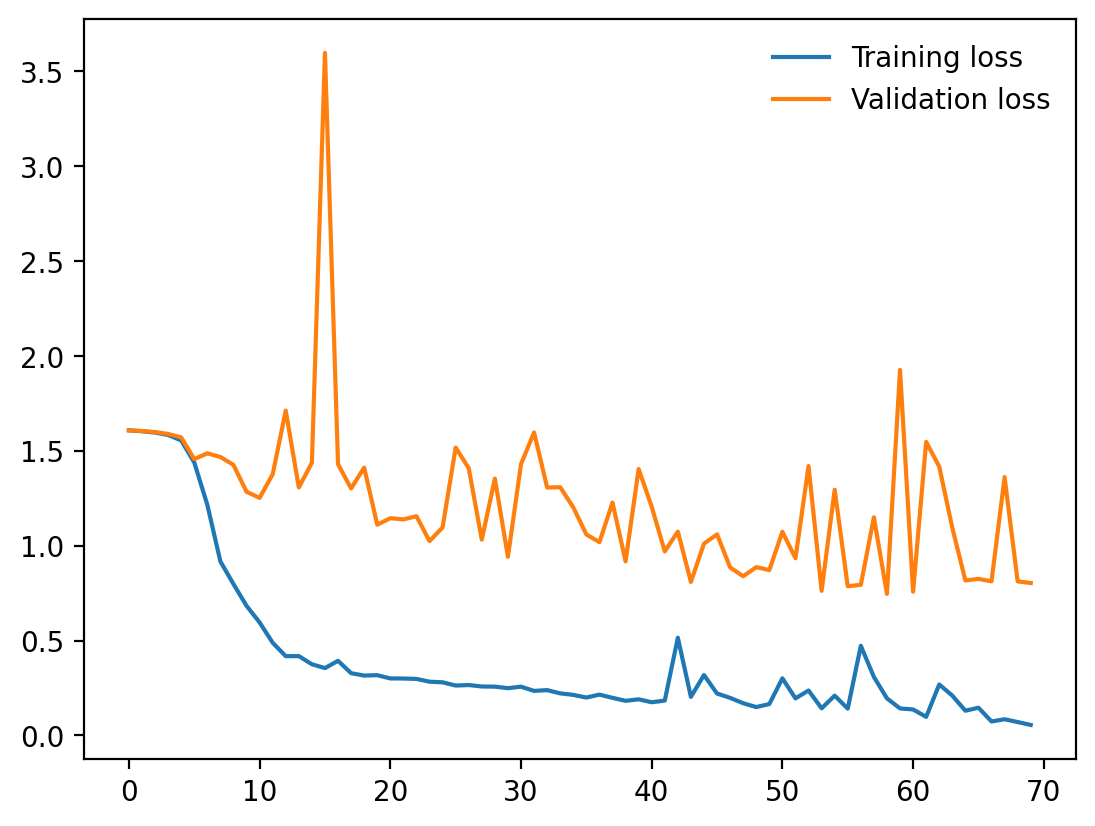

In [8]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [9]:
torch.save(model.state_dict(), 'modelo_overfitting_70.pth')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.
